In [9]:
import pandas as pd
import h5py
from tqdm import tqdm

# Load Data

In [10]:
import h5py
import numpy as np
import pandas as pd

filename = '../data/9606.protein.network.embeddings.v12.0 (1).h5'

with h5py.File(filename, 'r') as f:
    meta_keys = f['metadata'].attrs.keys()
    for key in meta_keys:
        print(key, f['metadata'].attrs[key])
    
    embedding = f['embeddings'][:]
    proteins = f['proteins'][:]
    proteins = [p.decode('utf-8') for p in proteins]

# Create DataFrame with one column containing the vector arrays
network_vector_df = pd.DataFrame({
    'embedding_vector': [np.array(vec) for vec in embedding]
}, index=proteins)

embedding_dim 512
n_proteins 19699
precision 16


In [11]:
enrichment_df = pd.read_csv('../data/9606.protein.enrichment.terms.v12.0.txt.gz', 
                          sep='\t',  
                          compression='gzip')

enrichment_df.set_index('#string_protein_id', inplace=True)

In [12]:
go_categories = [
    'Biological Process (Gene Ontology)',
]

go_enrichment_df = enrichment_df[enrichment_df['category'].isin(go_categories)]


# Combine Data

In [24]:
# First group go_enrichment_df by index and aggregate descriptions into lists
go_descriptions = go_enrichment_df.groupby(level=0)['description'].agg(lambda x: list(set(x)))

# Calculate frequency of each GO term (counting once per protein)
term_frequencies = {}
total_proteins = len(go_descriptions)
for terms in go_descriptions:
    unique_terms = set(terms)
    for term in unique_terms:
        term_frequencies[term] = term_frequencies.get(term, 0) + 1

# Convert to percentages
term_percentages = {term: count/total_proteins for term, count in term_frequencies.items()}

# Find terms that appear in more than 1% of proteins
common_terms = {term for term, percentage in term_percentages.items() if percentage > 0.01}

# Filter out common terms while preserving proteins that only have common terms
def filter_common_terms(terms):
    filtered_terms = [term for term in terms if term not in common_terms]
    if not filtered_terms:
        least_common = min(terms, key=lambda x: term_percentages[x])
        return [least_common]
    return filtered_terms

# Apply initial common terms filtering
filtered_go_descriptions = go_descriptions.apply(filter_common_terms)

# Create initial combined DataFrame
combined_df = pd.DataFrame({
    'embedding_vector': network_vector_df['embedding_vector'],
    'go_terms': filtered_go_descriptions
})

# Drop NAs
combined_df = combined_df.dropna(subset=['go_terms'])

# Now filter based on term counts (minimum 11 proteins per term)
term_counts = {}
for terms in combined_df['go_terms']:
    for term in terms:
        term_counts[term] = term_counts.get(term, 0) + 1

# Get valid terms (those with >= 11 proteins)
valid_terms = {term for term, count in term_counts.items() if count >= 2}

# Filter terms
def filter_low_count_terms(terms):
    filtered = [term for term in terms if term in valid_terms]
    return filtered

# Apply filtering and remove empty proteins
combined_df['go_terms'] = combined_df['go_terms'].apply(filter_low_count_terms)
combined_df = combined_df[combined_df['go_terms'].map(len) > 0]

# Now create the binary vectors
all_go_terms = sorted(valid_terms)  # Sort for consistent ordering
term_to_idx = {term: idx for idx, term in enumerate(all_go_terms)}
idx_to_term = {idx: term for term, idx in term_to_idx.items()}

def terms_to_binary_vector(terms):
    vector = [0] * len(all_go_terms)
    for term in terms:
        if term in term_to_idx:  # Safety check
            vector[term_to_idx[term]] = 1
    return vector

# Add binary vectors
combined_df['go_vector'] = combined_df['go_terms'].apply(terms_to_binary_vector)

# Print statistics
print("Number of proteins:", len(combined_df))
print("Number of GO terms:", len(all_go_terms))
print("\nDistribution of terms per protein:")
terms_per_protein = combined_df['go_terms'].map(len)
print(f"Mean: {terms_per_protein.mean():.2f}")
print(f"Median: {terms_per_protein.median():.2f}")
print(f"Min: {terms_per_protein.min()}")
print(f"Max: {terms_per_protein.max()}")

# Verify term frequencies in binary vectors
go_matrix = np.array(combined_df['go_vector'].tolist())
term_frequencies = go_matrix.sum(axis=0)
print("\nBinary vector statistics:")
print(f"Min proteins per term: {term_frequencies.min()}")
print(f"Max proteins per term: {term_frequencies.max()}")
print(f"Mean proteins per term: {term_frequencies.mean():.2f}")

# Save term mappings for later use
term_mappings = {
    'term_to_idx': term_to_idx,
    'idx_to_term': idx_to_term
}

Number of proteins: 17167
Number of GO terms: 12110

Distribution of terms per protein:
Mean: 15.43
Median: 7.00
Min: 1
Max: 453

Binary vector statistics:
Min proteins per term: 2
Max proteins per term: 377
Mean proteins per term: 21.87


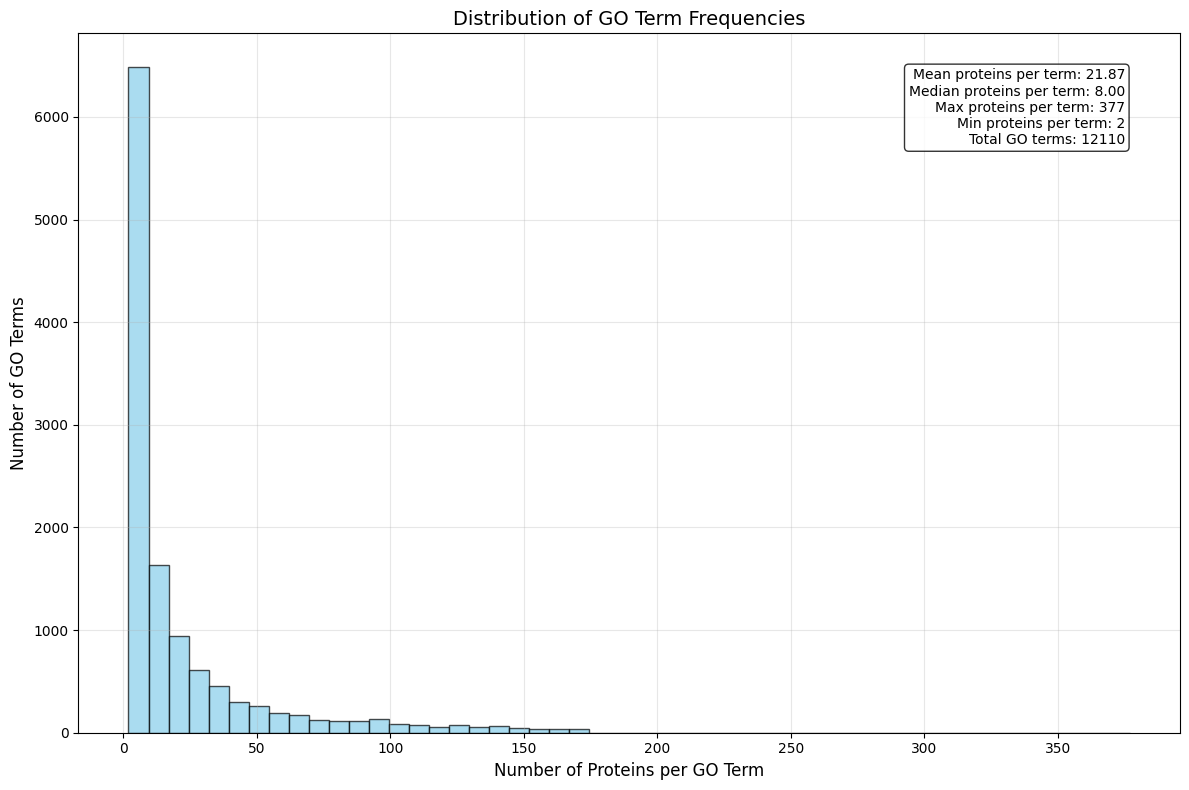

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the binary vectors to a numpy array for easier column-wise operations
go_matrix = np.array(combined_df['go_vector'].tolist())

# Sum across proteins to get count of proteins per GO term
proteins_per_term = go_matrix.sum(axis=0)

# Create histogram with improved styling
fig, ax = plt.subplots(figsize=(12, 8))
counts, bins, _ = plt.hist(proteins_per_term, 
                         bins=50, 
                         edgecolor='black',
                         color='skyblue',
                         alpha=0.7)

plt.xlabel('Number of Proteins per GO Term', fontsize=12)
plt.ylabel('Number of GO Terms', fontsize=12)
plt.title('Distribution of GO Term Frequencies', fontsize=14)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Calculate statistics
stats_text = (
   f"Mean proteins per term: {proteins_per_term.mean():.2f}\n"
   f"Median proteins per term: {np.median(proteins_per_term):.2f}\n"
   f"Max proteins per term: {proteins_per_term.max()}\n"
   f"Min proteins per term: {proteins_per_term.min()}\n"
   f"Total GO terms: {len(proteins_per_term)}"
)

# Add text box with statistics
plt.text(0.95, 0.95, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', 
                 facecolor='white', 
                 alpha=0.8))

plt.tight_layout()
plt.show()

100%|██████████| 5317/5317 [00:34<00:00, 152.74it/s]


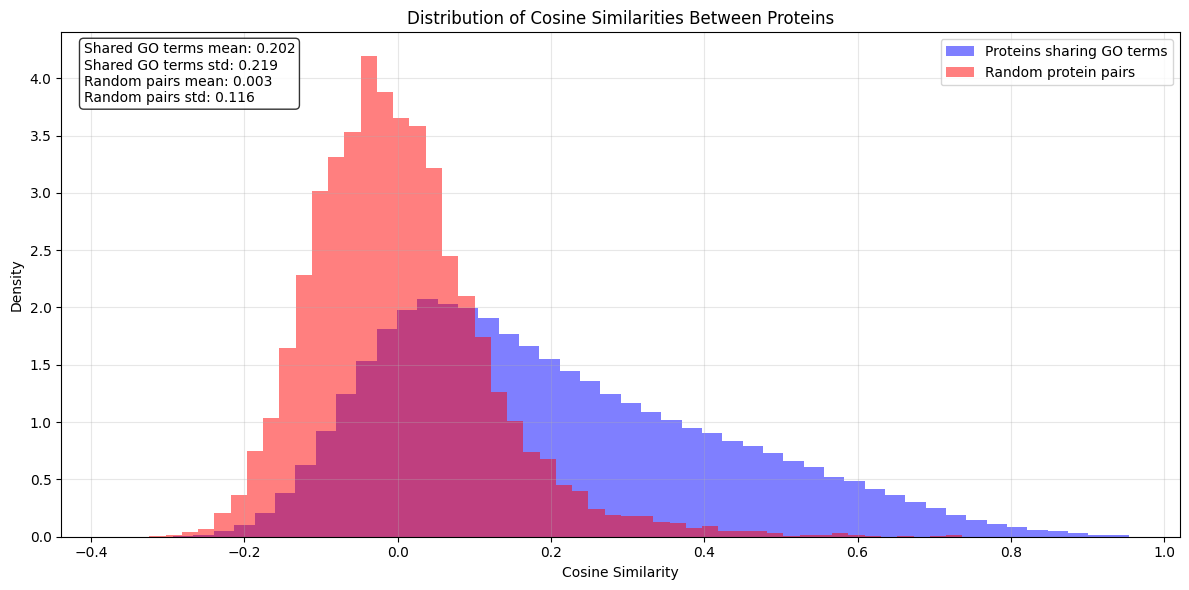

In [16]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
X = np.array(combined_df['embedding_vector'].tolist())

# Convert GO vectors to numpy array
y = np.array(combined_df['go_vector'].tolist())
# Lists to store similarities
same_go_similarities = []
different_go_similarities = []

# Sample size for different-GO comparisons (to keep computation manageable)
n_samples = 10000

# Calculate similarities for proteins sharing GO terms
for i in tqdm(range(y.shape[1])):
    # Get proteins that share this GO term
    positive_indices = np.where(y[:, i] == 1)[0]
    
    if len(positive_indices) < 2:  # Skip if not enough proteins
        continue
        
    # Sample pairs of proteins that share this GO term
    for _ in range(min(100, len(positive_indices))):  # Limit samples per term
        idx1, idx2 = np.random.choice(positive_indices, 2, replace=False)
        sim = cosine_similarity(X[idx1].reshape(1, -1), X[idx2].reshape(1, -1))[0][0]
        same_go_similarities.append(sim)

# Sample random pairs of proteins (regardless of GO terms) for comparison
all_indices = np.arange(len(X))
for _ in range(n_samples):
    idx1, idx2 = np.random.choice(all_indices, 2, replace=False)
    sim = cosine_similarity(X[idx1].reshape(1, -1), X[idx2].reshape(1, -1))[0][0]
    different_go_similarities.append(sim)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot histograms
plt.hist(same_go_similarities, bins=50, alpha=0.5, density=True, 
         label='Proteins sharing GO terms', color='blue')
plt.hist(different_go_similarities, bins=50, alpha=0.5, density=True,
         label='Random protein pairs', color='red')

plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title('Distribution of Cosine Similarities Between Proteins')
plt.legend()

# Add summary statistics
stats_text = (
    f"Shared GO terms mean: {np.mean(same_go_similarities):.3f}\n"
    f"Shared GO terms std: {np.std(same_go_similarities):.3f}\n"
    f"Random pairs mean: {np.mean(different_go_similarities):.3f}\n"
    f"Random pairs std: {np.std(different_go_similarities):.3f}"
)

plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Vectorized calculation of average similarities for each GO term
go_term_avg_similarities = []

for i in tqdm(range(y.shape[1])):
    positive_indices = np.where(y[:, i] == 1)[0]
    
    if len(positive_indices) < 2:  # Skip if not enough proteins
        continue
    
    # Get all positive proteins' embeddings at once
    pos_embeddings = X[positive_indices]
    
    # Calculate all pairwise similarities in one go
    similarities = cosine_similarity(pos_embeddings)
    
    # Get upper triangle values (excluding diagonal)
    upper_triangle = similarities[np.triu_indices_from(similarities, k=1)]
    
    # Store the average similarity for this term
    go_term_avg_similarities.append(np.mean(upper_triangle))

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(go_term_avg_similarities, bins=50, edgecolor='black')
plt.xlabel('Average Cosine Similarity')
plt.ylabel('Number of GO Terms')
plt.title('Distribution of Average Cosine Similarities Within GO Terms')

# Add summary statistics
stats_text = (
    f"Number of GO terms: {len(go_term_avg_similarities)}\n"
    f"Mean: {np.mean(go_term_avg_similarities):.3f}\n"
    f"Std: {np.std(go_term_avg_similarities):.3f}\n"
    f"Min: {np.min(go_term_avg_similarities):.3f}\n"
    f"Max: {np.max(go_term_avg_similarities):.3f}"
)

plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Balance positives and Negatives

100%|██████████| 5317/5317 [00:24<00:00, 214.50it/s]


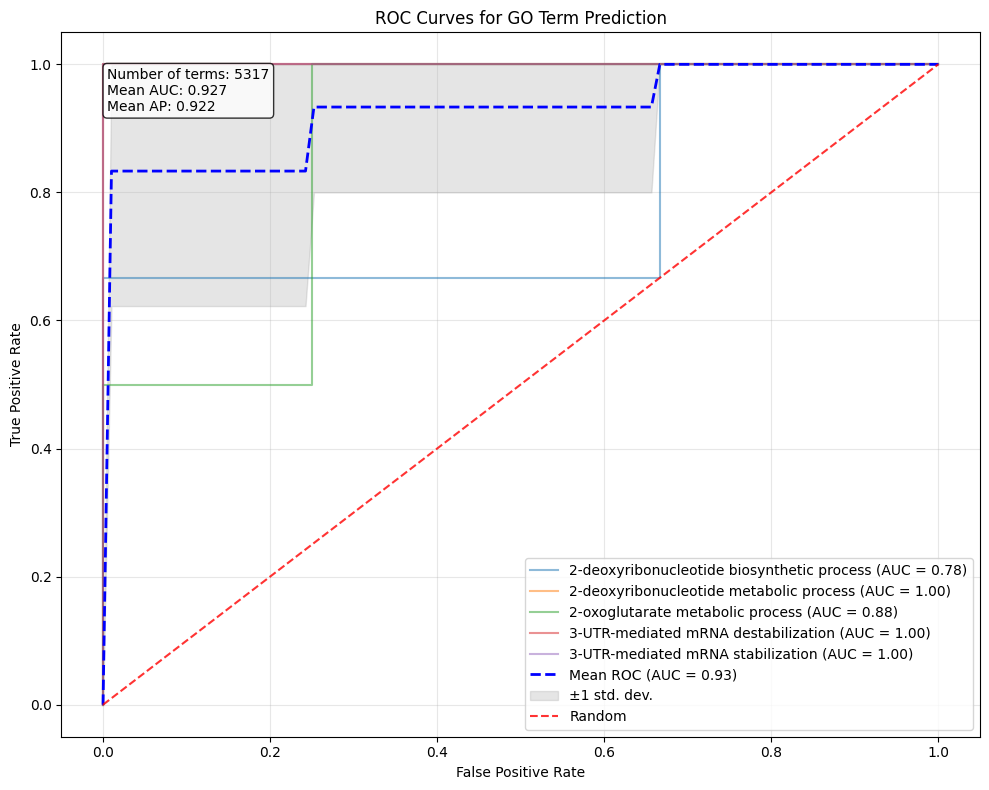


Total GO terms: 5317
Terms with sufficient examples: 5317
Mean AUC across valid terms: 0.927
Mean Average Precision: 0.922


In [18]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score 
import numpy as np
import warnings
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

X = np.array(combined_df['embedding_vector'].tolist())

# Convert GO vectors to numpy array
y = np.array(combined_df['go_vector'].tolist())


# Lists to store predictions and true labels for ROC curves
models = []
scores = []
valid_terms = []
all_predictions = []
all_labels = []
term_indices = []

for i in tqdm(range(y.shape[1])):
    if sum(y[:, i]) == 0 or sum(y[:, i]) == len(y):
        continue
        
    pos_indices = np.where(y[:, i] == 1)[0]
    neg_indices = np.where(y[:, i] == 0)[0]
    
    pos_train_idx, pos_test_idx = train_test_split(
        pos_indices,
        test_size=0.2,
        random_state=42
    )
    
    n_pos_train = len(pos_train_idx)
    n_pos_test = len(pos_test_idx)
    
    neg_train_idx = np.random.choice(neg_indices, size=n_pos_train, replace=False)
    remaining_neg = np.setdiff1d(neg_indices, neg_train_idx)
    neg_test_idx = np.random.choice(remaining_neg, size=n_pos_test, replace=False)
    
    train_indices = np.concatenate([pos_train_idx, neg_train_idx])
    test_indices = np.concatenate([pos_test_idx, neg_test_idx])
    
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices, i]
    y_test = y[test_indices, i]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Store predictions and true labels
    all_predictions.append(y_pred_prob)
    all_labels.append(y_test)
    term_indices.append(i)
    
    models.append(model)
    valid_terms.append(i)
    
    ap_score = average_precision_score(y_test, y_pred_prob)
    scores.append(ap_score)

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Initialize arrays for mean ROC curve
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

# Plot individual ROC curves for first 5 terms
for idx in range(min(5, len(term_indices))):
    fpr, tpr, _ = roc_curve(all_labels[idx], all_predictions[idx])
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Interpolate TPR values
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    plt.plot(fpr, tpr, alpha=0.5,
             label=f'{all_go_terms[term_indices[idx]]} (AUC = {roc_auc:.2f})')

# Calculate mean TPR and standard deviation
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_tpr = np.std(tprs, axis=0)

# Plot mean ROC curve
plt.plot(mean_fpr, mean_tpr, 'b--',
         label=f'Mean ROC (AUC = {mean_auc:.2f})',
         linewidth=2)

# Add confidence interval
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2,
                 label=f'±1 std. dev.')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'r--', label='Random', alpha=0.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for GO Term Prediction')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Add statistics text box
stats_text = (
    f"Number of terms: {len(term_indices)}\n"
    f"Mean AUC: {mean_auc:.3f}\n"
    f"Mean AP: {np.mean(scores):.3f}"
)

plt.text(0.05, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\nTotal GO terms: {y.shape[1]}")
print(f"Terms with sufficient examples: {len(valid_terms)}")
print(f"Mean AUC across valid terms: {mean_auc:.3f}")
print(f"Mean Average Precision: {np.mean(scores):.3f}")

In [19]:
# Each model has shape (n_features,) for its coefficients
all_weights = np.stack([model.coef_[0] for model in models])  # Shape: (n_models, n_features)

# Average across all models for each feature
average_weights = np.mean(all_weights, axis=0)  # Shape: (n_features,)

print("Shape of averaged weight vector:", average_weights.shape)
print("\nSummary statistics of averaged weights:")
print(f"Mean: {np.mean(average_weights):.4f}")
print(f"Std: {np.std(average_weights):.4f}")
print(f"Min: {np.min(average_weights):.4f}")
print(f"Max: {np.max(average_weights):.4f}")


np.save('average_weights.npy', average_weights)

Shape of averaged weight vector: (512,)

Summary statistics of averaged weights:
Mean: -0.0007
Std: 0.0429
Min: -0.1578
Max: 0.1426


# cosine baseline

100%|██████████| 5317/5317 [00:50<00:00, 106.07it/s]


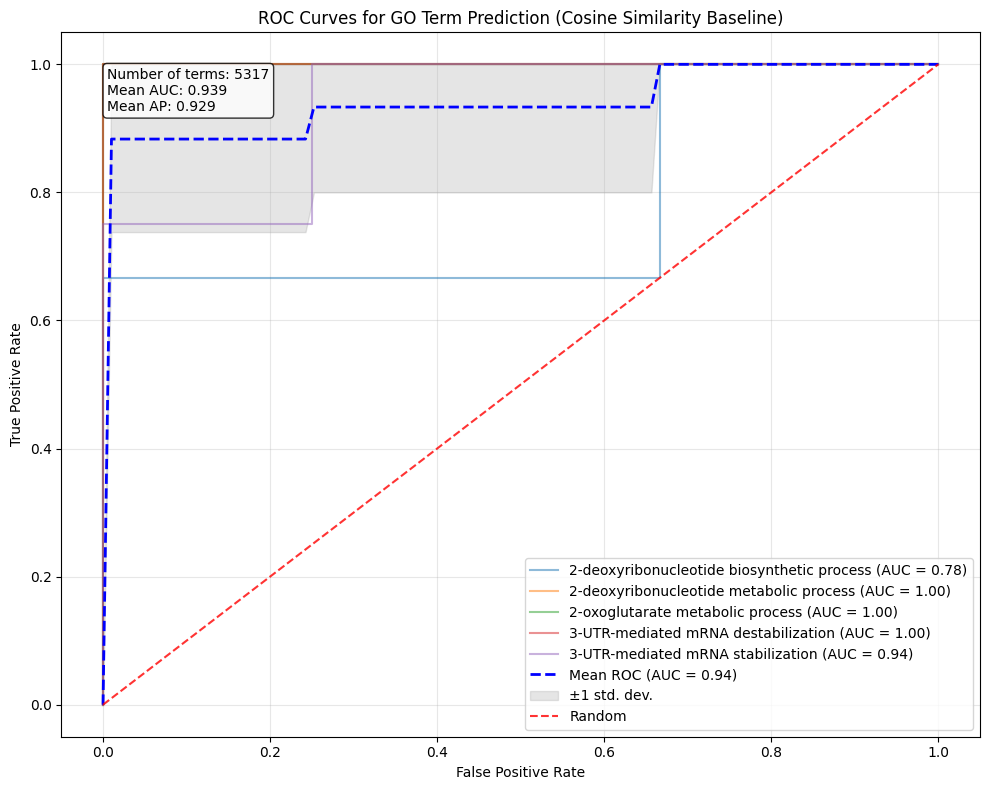


Total GO terms: 5317
Terms with sufficient examples: 5317
Mean AUC across valid terms: 0.939
Mean Average Precision: 0.929


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize_scalar
X = np.array(combined_df['embedding_vector'].tolist())

# Convert GO vectors to numpy array
y = np.array(combined_df['go_vector'].tolist())

# Lists to store predictions and true labels for ROC curves
cos_sim_predictions = []
cos_sim_labels = []
cos_sim_scores = []
cos_sim_valid_terms = []
optimal_thresholds = {}

def find_optimal_threshold(similarities, labels):
    # Function to optimize
    def objective(threshold):
        return -average_precision_score(labels, (similarities >= threshold).astype(float))
    
    # Find optimal threshold
    result = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    return result.x

for i in tqdm(range(y.shape[1])):
    if sum(y[:, i]) == 0 or sum(y[:, i]) == len(y):
        continue
        
    pos_indices = np.where(y[:, i] == 1)[0]
    neg_indices = np.where(y[:, i] == 0)[0]
    
    # Split the positive examples
    pos_train_idx, pos_test_idx = train_test_split(
        pos_indices,
        test_size=0.2,
        random_state=42
    )
    
    # Match the numbers for negative examples
    n_pos_train = len(pos_train_idx)
    n_pos_test = len(pos_test_idx)
    
    neg_train_idx = np.random.choice(neg_indices, size=n_pos_train, replace=False)
    remaining_neg = np.setdiff1d(neg_indices, neg_train_idx)
    neg_test_idx = np.random.choice(remaining_neg, size=n_pos_test, replace=False)
    
    # Combine indices
    train_indices = np.concatenate([pos_train_idx, neg_train_idx])
    test_indices = np.concatenate([pos_test_idx, neg_test_idx])
    
    # Select a reference positive example from training set
    reference_vector = np.mean(X[pos_train_idx], axis=0)
    
    # Calculate cosine similarities for test set
    similarities = cosine_similarity(X[test_indices], reference_vector.reshape(1, -1)).flatten()
    
    # Find optimal threshold using training data
    train_similarities = cosine_similarity(X[train_indices], reference_vector.reshape(1, -1)).flatten()
    optimal_threshold = find_optimal_threshold(train_similarities, y[train_indices, i])
    # After finding optimal threshold
    optimal_thresholds[i] = optimal_threshold
    # Store predictions and true labels
    cos_sim_predictions.append(similarities)
    cos_sim_labels.append(y[test_indices, i])
    cos_sim_valid_terms.append(i)
    
    # Calculate and store AP score
    ap_score = average_precision_score(y[test_indices, i], similarities)
    cos_sim_scores.append(ap_score)

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Initialize arrays for mean ROC curve
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

# Plot individual ROC curves for first 5 terms
for idx in range(min(5, len(cos_sim_valid_terms))):
    fpr, tpr, _ = roc_curve(cos_sim_labels[idx], cos_sim_predictions[idx])
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Interpolate TPR values
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    plt.plot(fpr, tpr, alpha=0.5,
             label=f'{all_go_terms[cos_sim_valid_terms[idx]]} (AUC = {roc_auc:.2f})')

# Calculate mean TPR and standard deviation
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_tpr = np.std(tprs, axis=0)

# Plot mean ROC curve
plt.plot(mean_fpr, mean_tpr, 'b--',
         label=f'Mean ROC (AUC = {mean_auc:.2f})',
         linewidth=2)

# Add confidence interval
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2,
                 label=f'±1 std. dev.')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'r--', label='Random', alpha=0.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for GO Term Prediction (Cosine Similarity Baseline)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Add statistics text box
stats_text = (
    f"Number of terms: {len(cos_sim_valid_terms)}\n"
    f"Mean AUC: {mean_auc:.3f}\n"
    f"Mean AP: {np.mean(cos_sim_scores):.3f}"
)

plt.text(0.05, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\nTotal GO terms: {y.shape[1]}")
print(f"Terms with sufficient examples: {len(cos_sim_valid_terms)}")
print(f"Mean AUC across valid terms: {mean_auc:.3f}")
print(f"Mean Average Precision: {np.mean(cos_sim_scores):.3f}")

Mean threshold: 0.259
Min threshold: 0.035
Max threshold: 0.910
Std threshold: 0.087


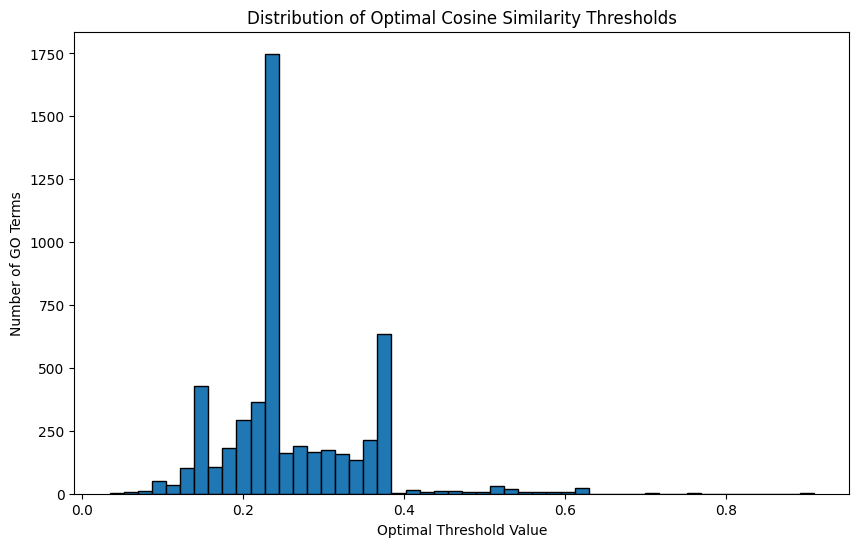

In [21]:
# Print distribution of optimal thresholds
thresholds = list(optimal_thresholds.values())
print(f"Mean threshold: {np.mean(thresholds):.3f}")
print(f"Min threshold: {np.min(thresholds):.3f}")
print(f"Max threshold: {np.max(thresholds):.3f}")
print(f"Std threshold: {np.std(thresholds):.3f}")

# Plot histogram of thresholds
plt.figure(figsize=(10, 6))
plt.hist(thresholds, bins=50, edgecolor='black')
plt.xlabel('Optimal Threshold Value')
plt.ylabel('Number of GO Terms')
plt.title('Distribution of Optimal Cosine Similarity Thresholds')
plt.show()

# Weighted Cosine Sim as determinant of shared Function

continuous method

In [22]:
X = np.array(combined_df['embedding_vector'].tolist())

# Convert GO vectors to numpy array
y = np.array(combined_df['go_vector'].tolist())

# Create all pairs of proteins that share terms and their scores
positive_pairs = []
positive_scores = []

# For each GO term
print("Processing GO terms for positive pairs...")
for term_idx in tqdm(range(y.shape[1])):
    # Get proteins that have this term
    proteins_with_term = np.where(y[:, term_idx] == 1)[0]
    n_proteins = len(proteins_with_term)
    
    if n_proteins < 2:  # Skip if not enough proteins
        continue
    
    # Create all pairs using mesh grid
    idx1, idx2 = np.meshgrid(np.arange(n_proteins), np.arange(n_proteins))
    valid_pairs = idx1 < idx2
    prot1 = proteins_with_term[idx1[valid_pairs]]
    prot2 = proteins_with_term[idx2[valid_pairs]]
    
    # Find shared terms for all pairs at once
    shared_mask = (y[prot1] == 1) & (y[prot2] == 1)
    term_counts = y.sum(axis=0)
    
    # Get minimum count for each pair's shared terms
    min_counts = np.array([term_counts[mask].min() for mask in shared_mask])
    scores = 1.0 / min_counts
    
    positive_pairs.extend(zip(prot1, prot2))
    positive_scores.extend(scores)

positive_pairs = np.array(positive_pairs)
positive_scores = np.array(positive_scores)

# For negative pairs, let's be more strategic:
print("\nGenerating negative pairs...")
n_proteins = len(X)
n_negatives = min(len(positive_pairs), 10_000)  # Cap at 1M negative pairs

# Calculate term counts per protein
terms_per_protein = y.sum(axis=1)

# Generate negative pairs with similar term count distributions
negative_pairs = []
negative_scores = []

with tqdm(total=n_negatives) as pbar:
    while len(negative_pairs) < n_negatives:
        # Generate batch of pairs
        batch_size = min(10000, n_negatives - len(negative_pairs))
        
        # Sample proteins weighted by their inverse term count
        weights = 1.0 / (terms_per_protein + 1)
        weights = weights / weights.sum()
        
        prot1 = np.random.choice(n_proteins, size=batch_size, p=weights)
        prot2 = np.random.choice(n_proteins, size=batch_size, p=weights)
        
        # Filter valid pairs
        valid_mask = prot1 != prot2
        prot1 = prot1[valid_mask]
        prot2 = prot2[valid_mask]
        
        # Check for shared terms
        no_shared_terms = (y[prot1] & y[prot2]).sum(axis=1) == 0
        
        # Add valid negative pairs
        new_pairs = np.column_stack([prot1[no_shared_terms], prot2[no_shared_terms]])
        negative_pairs.extend(new_pairs)
        negative_scores.extend([0] * len(new_pairs))
        
        pbar.update(len(new_pairs))

negative_pairs = np.array(negative_pairs[:n_negatives])
negative_scores = np.array(negative_scores[:n_negatives])

# Combine positive and negative cases
all_pairs = np.vstack([positive_pairs, negative_pairs])
all_scores = np.concatenate([positive_scores, negative_scores])

# Print statistics
print("\nStatistics:")
print(f"Number of positive pairs: {len(positive_pairs)}")
print(f"Number of negative pairs: {len(negative_pairs)}")
print("\nScore statistics:")
print(f"Max score: {np.max(positive_scores):.3f}")
print(f"Min positive score: {np.min(positive_scores):.3f}")
print(f"Mean positive score: {np.mean(positive_scores):.3f}")

Processing GO terms for positive pairs...


100%|██████████| 5317/5317 [03:18<00:00, 26.80it/s]



Generating negative pairs...


100%|██████████| 10000/10000 [00:00<00:00, 148807.00it/s]


Statistics:
Number of positive pairs: 8909939
Number of negative pairs: 10000

Score statistics:
Max score: 0.091
Min positive score: 0.003
Mean positive score: 0.022


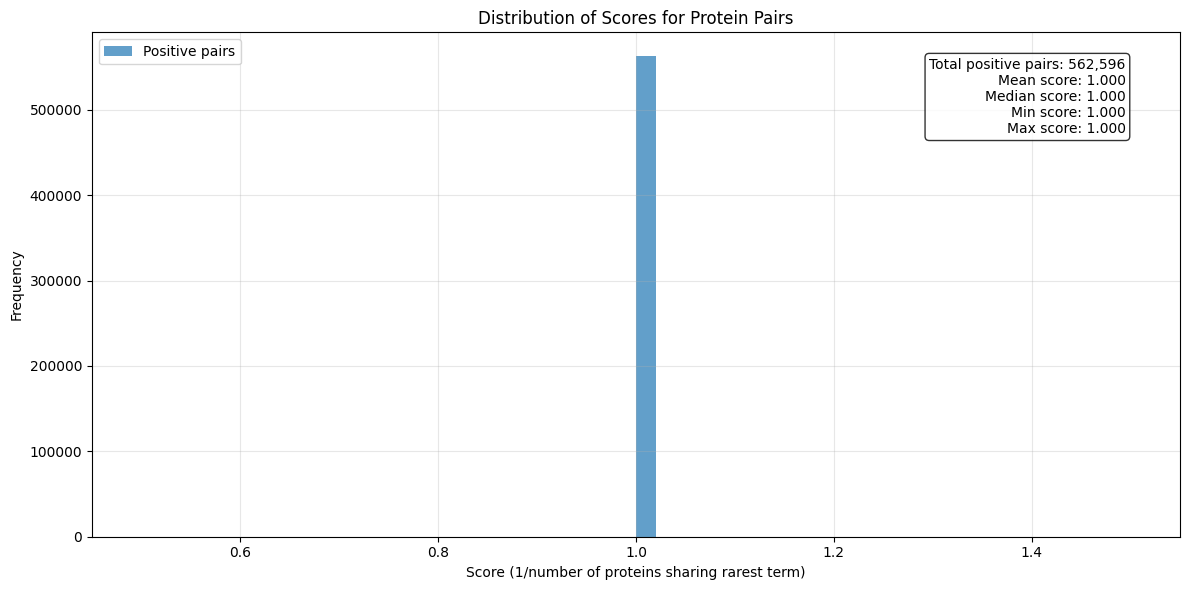

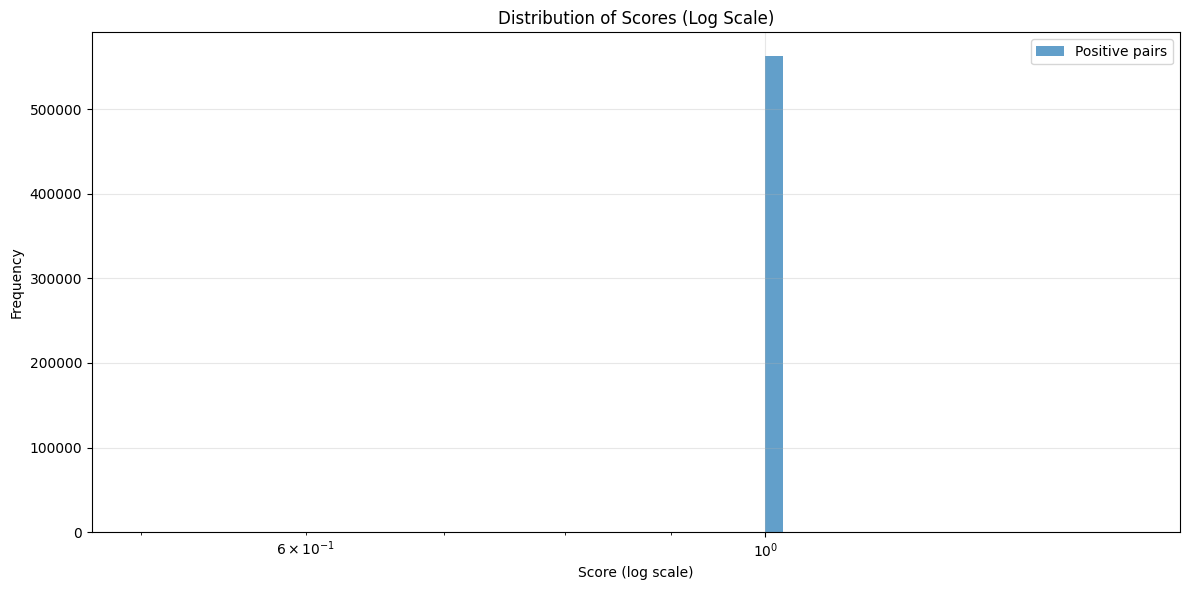

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Create main histogram
plt.hist(positive_scores, bins=50, alpha=0.7, label='Positive pairs')
plt.xlabel('Score (1/number of proteins sharing rarest term)')
plt.ylabel('Frequency')
plt.title('Distribution of Scores for Protein Pairs')
plt.legend()

# Add statistics text box
stats_text = (
    f"Total positive pairs: {len(positive_scores):,}\n"
    f"Mean score: {np.mean(positive_scores):.3f}\n"
    f"Median score: {np.median(positive_scores):.3f}\n"
    f"Min score: {np.min(positive_scores):.3f}\n"
    f"Max score: {np.max(positive_scores):.3f}"
)

plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Let's also show the distribution on a log scale
plt.figure(figsize=(12, 6))
plt.hist(positive_scores, bins=50, alpha=0.7, label='Positive pairs')
plt.xscale('log')
plt.xlabel('Score (log scale)')
plt.ylabel('Frequency')
plt.title('Distribution of Scores (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

binary method with group size cut off (remmeber to allow small protein groups less than whatever cut off we used for the other stuff)

In [28]:
X = np.array(combined_df['embedding_vector'].tolist())
y = np.array(combined_df['go_vector'].tolist())

# Create all pairs of proteins that share terms and their scores
positive_pairs = []
positive_scores = []

# For each GO term
print("Processing GO terms for positive pairs...")
for term_idx in tqdm(range(y.shape[1])):
    # Get proteins that have this term
    proteins_with_term = np.where(y[:, term_idx] == 1)[0]
    n_proteins = len(proteins_with_term)
    
    # Only process terms with 2-30 proteins
    if n_proteins < 2 or n_proteins > 30:
        continue
    
    # Create all pairs using mesh grid
    idx1, idx2 = np.meshgrid(np.arange(n_proteins), np.arange(n_proteins))
    valid_pairs = idx1 < idx2
    prot1 = proteins_with_term[idx1[valid_pairs]]
    prot2 = proteins_with_term[idx2[valid_pairs]]
    
    # Since we're only including groups < 30, all scores will be 1
    scores = np.ones(len(prot1))
    
    positive_pairs.extend(zip(prot1, prot2))
    positive_scores.extend(scores)

positive_pairs = np.array(positive_pairs)
positive_scores = np.array(positive_scores)

# Generate negative pairs
print("\nGenerating negative pairs...")
n_proteins = len(X)
n_negatives = min(len(positive_pairs), 500_000)

# Calculate term counts per protein
terms_per_protein = y.sum(axis=1)

negative_pairs = []
negative_scores = []

with tqdm(total=n_negatives) as pbar:
    while len(negative_pairs) < n_negatives:
        batch_size = min(10000, n_negatives - len(negative_pairs))
        
        # Sample proteins weighted by their inverse term count
        weights = 1.0 / (terms_per_protein + 1)
        weights = weights / weights.sum()
        
        prot1 = np.random.choice(n_proteins, size=batch_size, p=weights)
        prot2 = np.random.choice(n_proteins, size=batch_size, p=weights)
        
        valid_mask = prot1 != prot2
        prot1 = prot1[valid_mask]
        prot2 = prot2[valid_mask]
        
        no_shared_terms = (y[prot1] & y[prot2]).sum(axis=1) == 0
        
        new_pairs = np.column_stack([prot1[no_shared_terms], prot2[no_shared_terms]])
        negative_pairs.extend(new_pairs)
        negative_scores.extend([0] * len(new_pairs))
        
        pbar.update(len(new_pairs))

negative_pairs = np.array(negative_pairs[:n_negatives])
negative_scores = np.array(negative_scores[:n_negatives])

# Combine positive and negative cases
all_pairs = np.vstack([positive_pairs, negative_pairs])
all_scores = np.concatenate([positive_scores, negative_scores])

# Print statistics
print("\nStatistics:")
print(f"Number of positive pairs: {len(positive_pairs)}")
print(f"Number of negative pairs: {len(negative_pairs)}")
print("\nScore distribution:")
print(f"Number of 1s: {np.sum(all_scores == 1)}")
print(f"Number of 0s: {np.sum(all_scores == 0)}")

Processing GO terms for positive pairs...


100%|██████████| 12110/12110 [00:00<00:00, 13777.94it/s]



Generating negative pairs...


100%|██████████| 500000/500000 [00:26<00:00, 18864.54it/s]



Statistics:
Number of positive pairs: 562596
Number of negative pairs: 500000

Score distribution:
Number of 1s: 562596
Number of 0s: 500000


In [ ]:
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create train/test split
train_indices, test_indices = train_test_split(
    np.arange(len(all_pairs)), 
    test_size=0.2, 
    random_state=42
)

# Get train/test pairs and scores
train_pairs = all_pairs[train_indices]
test_pairs = all_pairs[test_indices]
y_train = all_scores[train_indices]
y_test = all_scores[test_indices]

def weighted_cosine_similarity(vec1, vec2, weights):
    """Calculate cosine similarity between two vectors using weights"""
    vec1_weighted = vec1 * weights
    vec2_weighted = vec2 * weights
    return np.dot(vec1_weighted, vec2_weighted) / (np.linalg.norm(vec1_weighted) * np.linalg.norm(vec2_weighted))

# Counter for progress bar in objective function
objective_counter = 0

def objective_function(weights, pairs, y_true):
    """
    Optimize weights to maximize cosine similarity for positive pairs and minimize for negative pairs
    """
    global objective_counter
    objective_counter += 1
    
    weights = weights / np.linalg.norm(weights)  # Normalize weights
    
    similarities = []
    for pair in tqdm(pairs, desc=f"Objective evaluation {objective_counter}", leave=False):
        sim = weighted_cosine_similarity(X[pair[0]], X[pair[1]], weights)
        similarities.append(sim)
    
    similarities = np.array(similarities)
    
    # Calculate loss
    pos_loss = -np.mean(similarities[y_true == 1])  # Want high similarity for positives
    neg_loss = np.mean(similarities[y_true == 0])   # Want low similarity for negatives
    
    return pos_loss + neg_loss

def evaluate_weights(weights, pairs, y_true):
    """Evaluate performance of weights on a dataset"""
    similarities = []
    for pair in tqdm(pairs, desc="Evaluating pairs"):
        sim = weighted_cosine_similarity(X[pair[0]], X[pair[1]], weights)
        similarities.append(sim)
    
    similarities = np.array(similarities)
    
    pos_sim = np.mean(similarities[y_true == 1])
    neg_sim = np.mean(similarities[y_true == 0])
    
    return similarities, pos_sim, neg_sim

def plot_similarity_distributions(similarities, y_true, title="Distribution of Weighted Similarities"):
    """Plot distribution of similarities for positive and negative pairs"""
    plt.figure(figsize=(10, 6))
    plt.hist(similarities[y_true == 1], bins=50, alpha=0.5, label='Positive pairs', density=True)
    plt.hist(similarities[y_true == 0], bins=50, alpha=0.5, label='Negative pairs', density=True)
    plt.xlabel('Weighted Cosine Similarity')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.show()


In [34]:

# Initialize and optimize weights
print("Initializing weights...")
initial_weights = np.ones(X.shape[1]) / np.sqrt(X.shape[1])

iteration_counter = 0

def print_iteration(xk):
    global iteration_counter
    iteration_counter += 1
    print(f"Optimization iteration: {iteration_counter}")

# Then modify your minimize call:
result = minimize(
    lambda w: objective_function(w, train_pairs, y_train),
    initial_weights,
    method='L-BFGS-B',
    options={'maxiter': 100},
    callback=print_iteration
)

optimized_weights = result.x / np.linalg.norm(result.x)

# Evaluate on train and test sets
print("\nEvaluating on training set...")
train_similarities, train_pos_sim, train_neg_sim = evaluate_weights(optimized_weights, train_pairs, y_train)

print("\nEvaluating on test set...")
test_similarities, test_pos_sim, test_neg_sim = evaluate_weights(optimized_weights, test_pairs, y_test)

# Print results
print("\nResults:")
print("Training set:")
print(f"Average similarity for positive pairs: {train_pos_sim:.3f}")
print(f"Average similarity for negative pairs: {train_neg_sim:.3f}")
print("\nTest set:")
print(f"Average similarity for positive pairs: {test_pos_sim:.3f}")
print(f"Average similarity for negative pairs: {test_neg_sim:.3f}")

# Plot distributions
print("\nPlotting similarity distributions...")
plot_similarity_distributions(train_similarities, y_train, "Training Set Similarity Distribution")
plot_similarity_distributions(test_similarities, y_test, "Test Set Similarity Distribution")

Initializing weights...


KeyboardInterrupt: 